In [30]:
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from waveprop.fresnel import fresnel_conv
from waveprop.rs import angular_spectrum
fresnel_conv, angular_spectrum

(<function waveprop.fresnel.fresnel_conv(u_in, wv, d1, dz, device=None, dtype=None, d2=None, pad=True)>,
 <function waveprop.rs.angular_spectrum(u_in, wv, d1, dz, bandlimit=True, out_shift=0, d2=None, N_out=None, pyffs=False, aperture=None, aperture_ft=None, in_shift=None, weights=None, dtype=None, return_H=False, return_H_exp=False, return_U1=False, H=None, H_exp=None, U1=None, device=None, pad=True)>)

(126, 126)

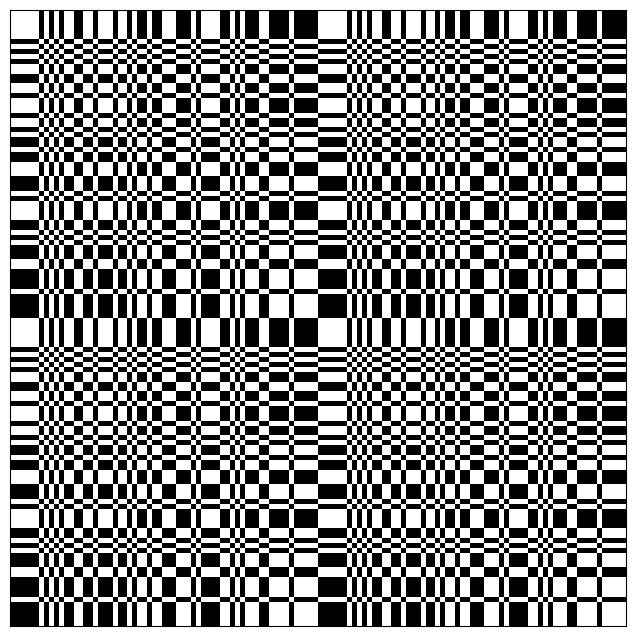

In [41]:
mask = np.load('../FlatCam/MLS/MLS_6bits.npy')
#mask = np.load('../PhlatCam/edges_dim256x256_res8x8.npy')
#mask = np.load('..//FresnelZoneAperture/fza_dim510x255_r30.npy')
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')
_ = plt.xticks([]), plt.yticks([])
mask.shape

(126, 126)

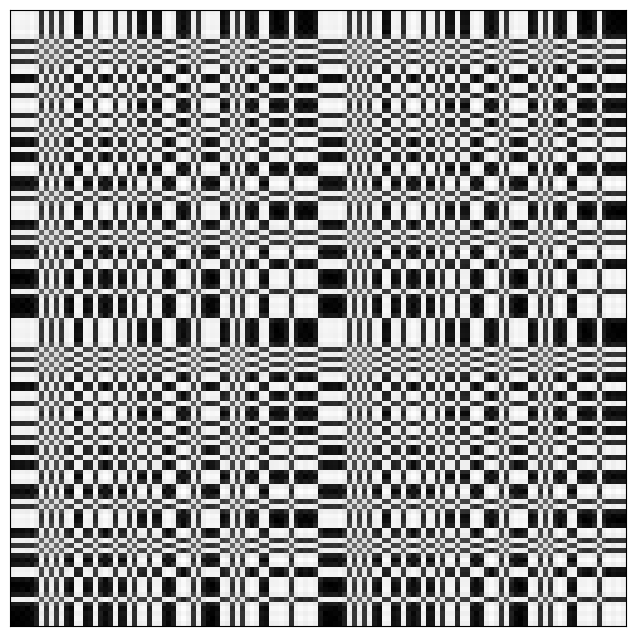

In [42]:
lambd, sensor_size, nb_px, dz = 532e-9, 5e-3, 256, 0.5e-3
d1 = sensor_size / nb_px

psf, _, _ = angular_spectrum(
    u_in=mask,
    wv=lambd,
    d1=d1,
    dz=dz,
    dtype=np.float32
)

plt.figure(figsize=(8,8))
plt.imshow(abs(psf), cmap='gray')
_ = plt.xticks([]), plt.yticks([])
psf.shape

In [38]:
def phase_mask_design(target_psf, lambd, d1, dz, n=1.5, n_iter=10):

    M_p = np.sqrt(target_psf)
    for _ in progressbar.ProgressBar()(range(n_iter)):
        M_phi = np.exp(1j * np.angle(fresnel_conv(M_p, lambd, d1, -dz, dtype=np.float32)[0]))
        M_p = np.sqrt(target_psf) * np.exp(1j * fresnel_conv(M_phi, lambd, d1, dz, dtype=np.float32)[0])    
    phi = np.angle(M_phi)

    return phi, lambd * phi / (2 * np.pi * (n-1))


In [39]:
phase = phase_mask_design(mask, lambd, d1, dz)

100% |########################################################################|


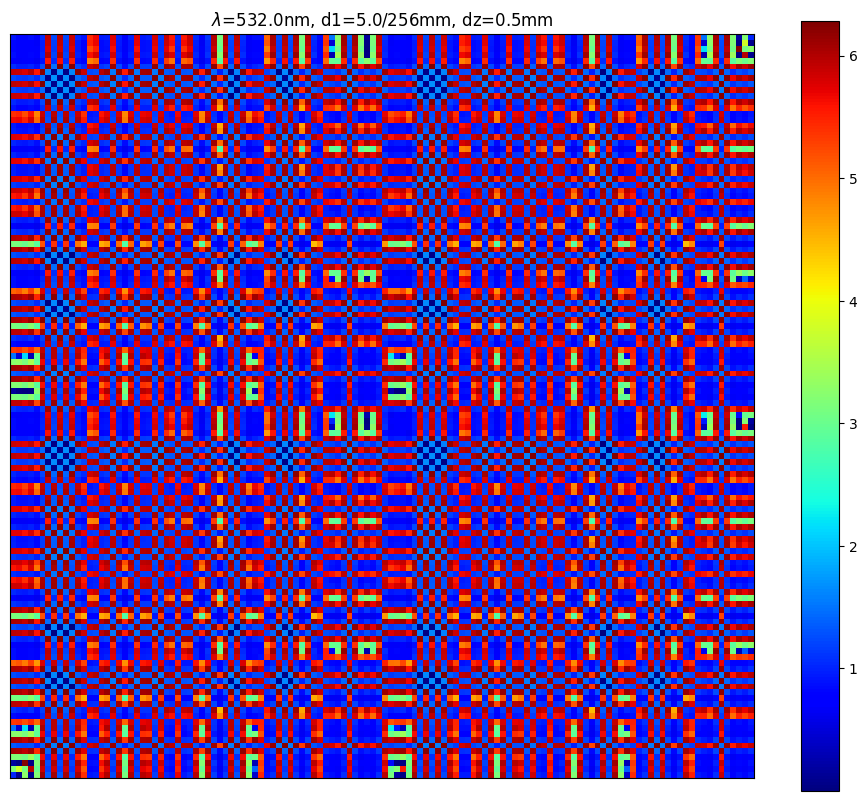

In [40]:
plt.figure(figsize=(12,10))
phase_mask = (phase[0] + 2 * np.pi) % (2 * np.pi)
plt.imshow(phase_mask, cmap='jet')
plt.title(f'$\lambda$={lambd*1e9}nm, d1={sensor_size*1e3}/{nb_px}mm, dz={dz*1e3}mm')
plt.colorbar()
_ = plt.xticks([]), plt.yticks([])

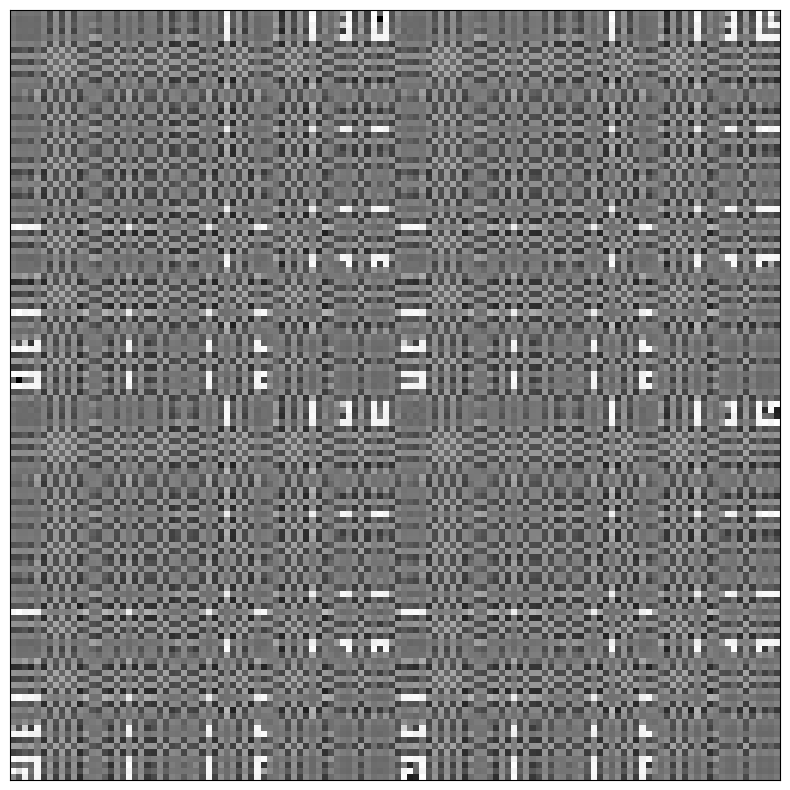

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(abs(fresnel_conv(phase[0], lambd, d1, dz)[0])), cmap='gray')
_ = plt.xticks([]), plt.yticks([])